## Installing Important Libraries

In [1]:
pip install librosa soundfile

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install pyaudio

In [3]:
!pip install imbalanced-learn

## Importing Libraries

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import IPython.display as ipd
import librosa
import librosa.display

In [7]:
import librosa
import soundfile
import os, glob, pickle
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

## Data Exploration

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

## Visuals of Every Class

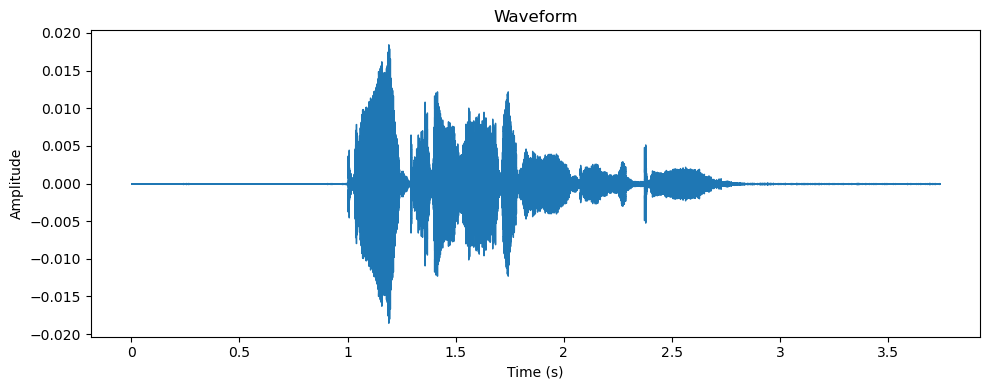

In [8]:
#calm
path = "C:/Users/Admin/OneDrive/Desktop/AudioFiles/03-01-02-02-02-01-14.wav"
audio, sample_rate = librosa.load(path, sr=None)

fig, ax = plt.subplots(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sample_rate, ax=ax)
ax.set(title="Waveform", xlabel="Time (s)", ylabel="Amplitude")
plt.tight_layout()
plt.show()

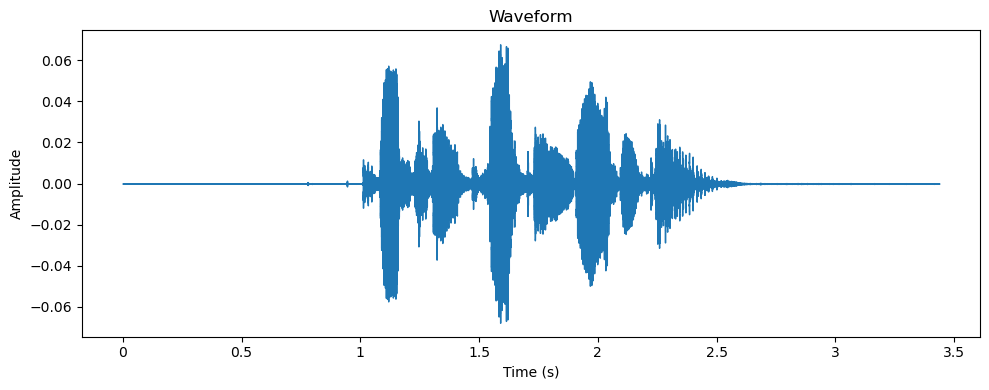

In [9]:
#neutral
import librosa
import librosa.display
import matplotlib.pyplot as plt

path = "C:/Users/Admin/OneDrive/Desktop/AudioFiles/03-01-01-01-01-01-03.wav"
audio, sample_rate = librosa.load(path, sr=None)

fig, ax = plt.subplots(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sample_rate, ax=ax)
ax.set(title="Waveform", xlabel="Time (s)", ylabel="Amplitude")
plt.tight_layout()
plt.show()

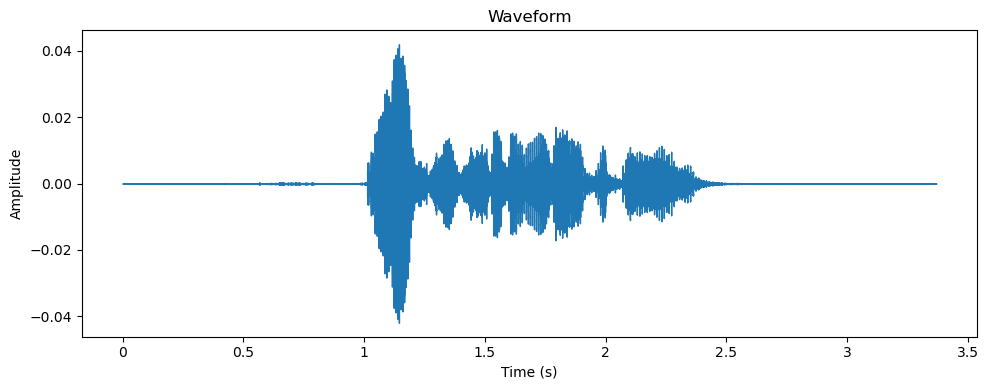

In [10]:
#sad
path = "C:/Users/Admin/OneDrive/Desktop/AudioFiles/03-01-04-01-02-02-13.wav"
audio, sample_rate = librosa.load(path, sr=None)

fig, ax = plt.subplots(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sample_rate, ax=ax)
ax.set(title="Waveform", xlabel="Time (s)", ylabel="Amplitude")
plt.tight_layout()
plt.show()

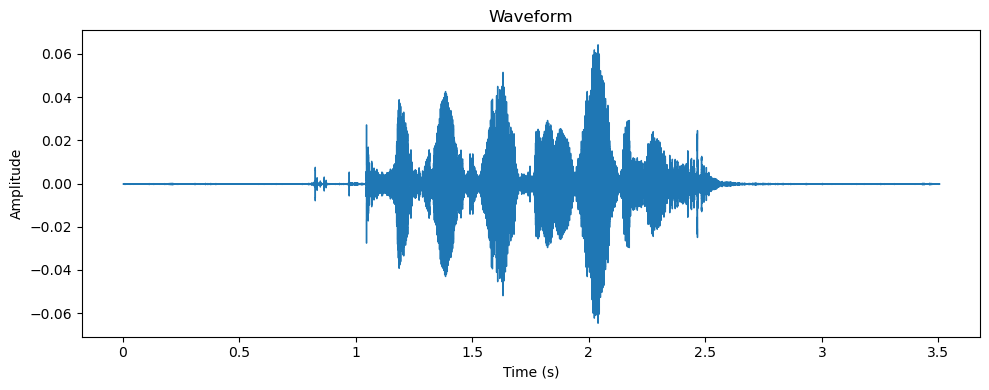

In [11]:
#happy
path = "C:/Users/Admin/OneDrive/Desktop/AudioFiles/03-01-03-01-01-01-08.wav"
audio, sample_rate = librosa.load(path, sr=None)

fig, ax = plt.subplots(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sample_rate, ax=ax)
ax.set(title="Waveform", xlabel="Time (s)", ylabel="Amplitude")
plt.tight_layout()
plt.show()

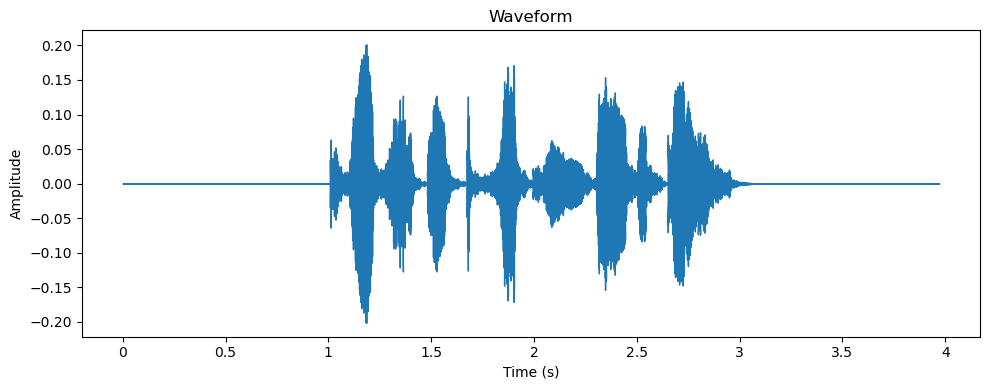

In [12]:
#angry
path = "C:/Users/Admin/OneDrive/Desktop/AudioFiles/03-01-05-01-01-01-16.wav"
audio, sample_rate = librosa.load(path, sr=None)

fig, ax = plt.subplots(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sample_rate, ax=ax)
ax.set(title="Waveform", xlabel="Time (s)", ylabel="Amplitude")
plt.tight_layout()
plt.show()

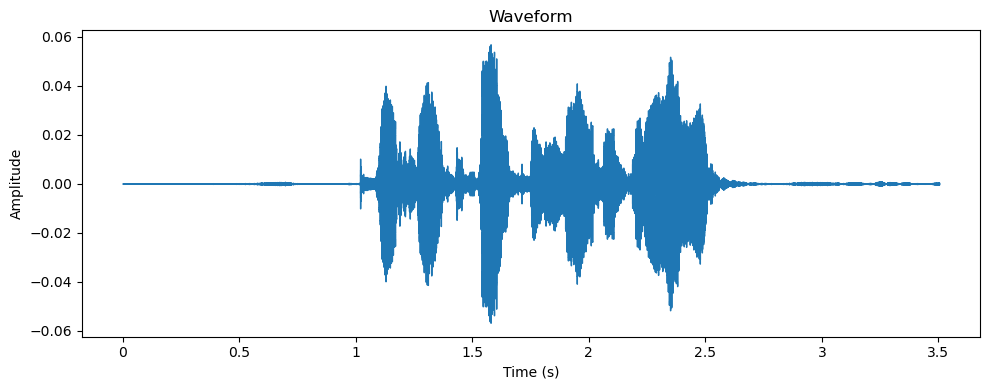

In [13]:
#fearful
path ="C:/Users/Admin/OneDrive/Desktop/AudioFiles/03-01-06-01-01-02-07.wav"
audio, sample_rate = librosa.load(path, sr=None)

fig, ax = plt.subplots(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sample_rate, ax=ax)
ax.set(title="Waveform", xlabel="Time (s)", ylabel="Amplitude")
plt.tight_layout()
plt.show()

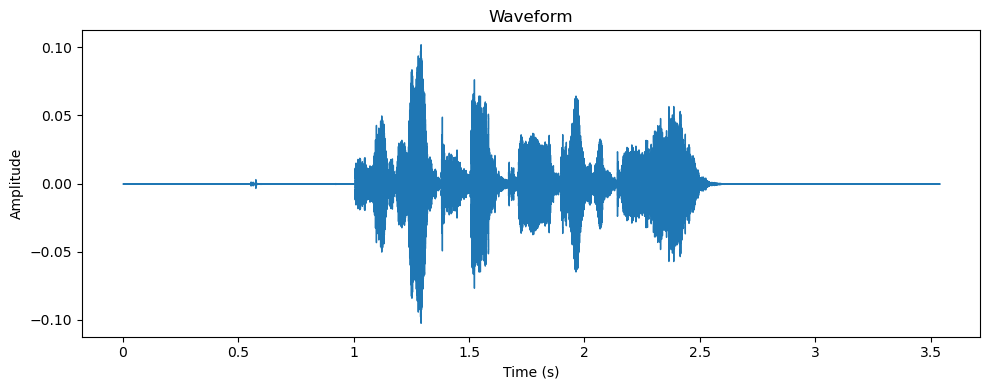

In [14]:
#surprised
path = "C:/Users/Admin/OneDrive/Desktop/AudioFiles/03-01-08-01-01-02-02.wav"
audio, sample_rate = librosa.load(path, sr=None)

fig, ax = plt.subplots(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sample_rate, ax=ax)
ax.set(title="Waveform", xlabel="Time (s)", ylabel="Amplitude")
plt.tight_layout()
plt.show()

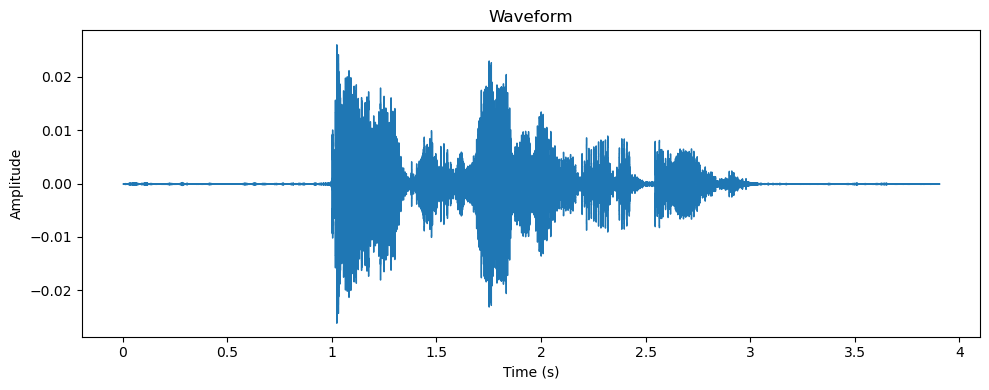

In [15]:
#disgust
path = "C:/Users/Admin/OneDrive/Desktop/AudioFiles/03-01-07-01-02-01-05.wav"
audio, sample_rate = librosa.load(path, sr=None)

fig, ax = plt.subplots(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sample_rate, ax=ax)
ax.set(title="Waveform", xlabel="Time (s)", ylabel="Amplitude")
plt.tight_layout()
plt.show()

## Function which Extract Features

In [16]:
emotions={
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'suprised'
}

observed_emotions=['neutral','calm','happy','sad','angry','fearful','disgust','suprised']

In [17]:
def extract_feature(file_name, mfcc, chroma, mel):
    audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    result = np.array([])
    if chroma:
        stft = np.abs(librosa.stft(audio_data))
    if mfcc:
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        mfccs_mean = np.mean(mfccs.T, axis=0)
        result = np.hstack((result, mfccs_mean))
    if chroma:
        chroma_feat = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
        chroma_mean = np.mean(chroma_feat.T, axis=0)
        result = np.hstack((result, chroma_mean))
    if mel:
        mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
        mel_mean = np.mean(mel_spec.T, axis=0)
        result = np.hstack((result, mel_mean))
    return result


## Feature Extraction

In [18]:
def load_data(test_size=0.2):
    x = []
    y = []

    audio_files = glob.glob("C:/Users/Admin/OneDrive/Desktop/AudioFiles/*.wav")

    for file_path in audio_files:
        file_name = os.path.basename(file_path)
        emotion_code = file_name.split("-")[2]
        emotion = emotions.get(emotion_code)

        if emotion not in observed_emotions:
            continue

        features = extract_feature(file_path, mfcc=True, chroma=True, mel=True)
        x.append(features)
        y.append(emotion)

    return x, y

In [19]:
X,y=load_data(test_size=0.20)

In [20]:
X=np.array(X)

In [21]:
from collections import Counter
class_counts = Counter(y)
for label, count in class_counts.items():
   print(f"{label}: {count}")

neutral: 188
calm: 376
happy: 376
sad: 376
angry: 376
fearful: 376
disgust: 192
suprised: 192


### Extracted features 

In [22]:
X

array([[-7.00048035e+02,  5.81418533e+01, -2.55860662e+00, ...,
         5.73651633e-08,  5.95472693e-09,  2.02506706e-10],
       [-6.52819153e+02,  5.75204277e+01, -1.21053476e+01, ...,
         7.08200432e-08,  4.79935380e-09,  2.61659638e-10],
       [-6.16739807e+02,  5.96001320e+01, -5.55065775e+00, ...,
         6.48230980e-07,  7.81329987e-08,  2.93670910e-09],
       ...,
       [-4.74032654e+02,  2.41930275e+01, -2.32327290e+01, ...,
         1.30318904e-05,  1.17621153e-06,  2.52888945e-08],
       [-4.63186035e+02,  5.93455391e+01, -2.50571995e+01, ...,
         1.81669675e-05,  1.18233049e-06,  2.97812051e-08],
       [-4.69516357e+02,  2.42484207e+01, -1.39602232e+01, ...,
         2.72247653e-05,  2.58740147e-06,  1.03642911e-07]])

In [23]:
X.shape

(2452, 180)

### Visualising Labels

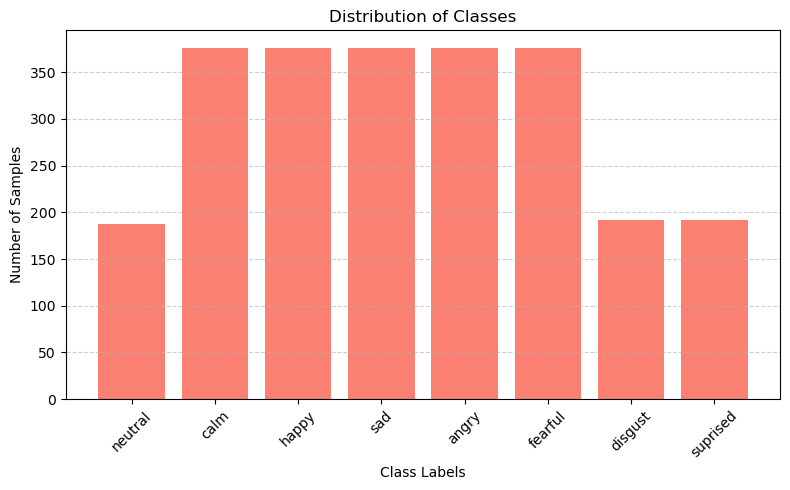

In [26]:
from collections import Counter
import matplotlib.pyplot as plt

# Count class occurrences
class_counts = Counter(y)
labels = list(class_counts.keys())
counts = list(class_counts.values())

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(labels, counts, color='salmon')  # Changed color from 'skyblue' to 'salmon'
ax.set_xlabel('Class Labels')
ax.set_ylabel('Number of Samples')
ax.set_title('Distribution of Classes')
ax.set_xticklabels(labels, rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Data Preprocessing

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [29]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)

# Wrap into Dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


## Model Creation and Fitting

In [30]:
import torch.nn as nn
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_classes=8):
        super(MLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),  # BN after Linear
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),  # BN after Linear
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.model(x)


input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = MLPClassifier(input_dim=input_dim, num_classes=num_classes)

In [31]:
def train(model, loader):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        output = model(X_batch)
        
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y_batch).sum().item()
            
            total += y_batch.size(0)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    acc = correct / total
    return acc, y_true, y_pred


In [32]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Accuracy Calculation

In [33]:
from sklearn.metrics import classification_report

epochs = 100
best_f1 = 0

for epoch in range(1, epochs + 1):
    train_loss = train(model, train_loader)
    val_acc, y_true, y_pred = evaluate(model, val_loader)
    report = classification_report(y_true, y_pred, output_dict=True)
    macro_f1 = report['macro avg']['f1-score']
    
    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | F1: {macro_f1:.4f}")

    if macro_f1 > best_f1:
        best_f1 = macro_f1
        torch.save(model.state_dict(), 'best_emotion_model.pth')

    # Early stopping if requirements are met
    if macro_f1 >= 0.80 and val_acc >= 0.80 and all(report[str(i)]['recall'] >= 0.75 for i in range(num_classes)):
        print("✅ Requirements met. Stopping early.")
        break

Epoch 1 | Train Loss: 1.8340 | Val Acc: 0.3931 | F1: 0.2950
Epoch 2 | Train Loss: 1.5375 | Val Acc: 0.5051 | F1: 0.4865
Epoch 3 | Train Loss: 1.3568 | Val Acc: 0.5682 | F1: 0.5457
Epoch 4 | Train Loss: 1.2694 | Val Acc: 0.5784 | F1: 0.5485
Epoch 5 | Train Loss: 1.1941 | Val Acc: 0.6273 | F1: 0.5998
Epoch 6 | Train Loss: 1.1222 | Val Acc: 0.6130 | F1: 0.5870
Epoch 7 | Train Loss: 1.0712 | Val Acc: 0.6314 | F1: 0.6009
Epoch 8 | Train Loss: 1.0338 | Val Acc: 0.6395 | F1: 0.6135
Epoch 9 | Train Loss: 0.9850 | Val Acc: 0.6456 | F1: 0.6174
Epoch 10 | Train Loss: 0.9985 | Val Acc: 0.6375 | F1: 0.6184
Epoch 11 | Train Loss: 0.9897 | Val Acc: 0.6354 | F1: 0.6026
Epoch 12 | Train Loss: 0.9425 | Val Acc: 0.6334 | F1: 0.6127
Epoch 13 | Train Loss: 0.9011 | Val Acc: 0.6436 | F1: 0.6226
Epoch 14 | Train Loss: 0.9258 | Val Acc: 0.6701 | F1: 0.6430
Epoch 15 | Train Loss: 0.8502 | Val Acc: 0.6640 | F1: 0.6406
Epoch 16 | Train Loss: 0.8562 | Val Acc: 0.6721 | F1: 0.6503
Epoch 17 | Train Loss: 0.8690 | V

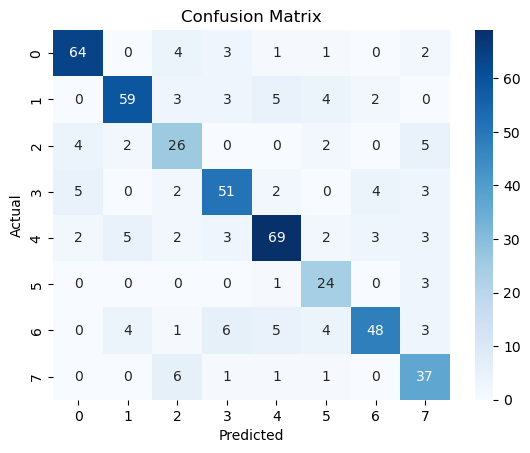

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        75
           1       0.84      0.78      0.81        76
           2       0.59      0.67      0.63        39
           3       0.76      0.76      0.76        67
           4       0.82      0.78      0.80        89
           5       0.63      0.86      0.73        28
           6       0.84      0.68      0.75        71
           7       0.66      0.80      0.73        46

    accuracy                           0.77       491
   macro avg       0.75      0.77      0.76       491
weighted avg       0.78      0.77      0.77       491



In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load best model
model.load_state_dict(torch.load('best_emotion_model.pth'))
_, y_true, y_pred = evaluate(model, val_loader)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_true, y_pred))

Accuracy is coming out very low, thats why i have removed two of the features-'neutral' and 'suprised'

# After Reducing Features

In [35]:
emotions={
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'suprised'
}
observed_emotions=['calm','happy','sad','angry','fearful','disgust']  #two features removed.

In [36]:
def extract_feature(file_name, mfcc, chroma, mel):
    audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    result = np.array([])
    if chroma:
        stft = np.abs(librosa.stft(audio_data))
    if mfcc:
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        mfccs_mean = np.mean(mfccs.T, axis=0)
        result = np.hstack((result, mfccs_mean))
    if chroma:
        chroma_feat = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
        chroma_mean = np.mean(chroma_feat.T, axis=0)
        result = np.hstack((result, chroma_mean))
    if mel:
        mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
        mel_mean = np.mean(mel_spec.T, axis=0)
        result = np.hstack((result, mel_mean))
    return result


In [37]:
def load_data(test_size=0.2):
    x = []
    y = []

    audio_files = glob.glob("C:/Users/Admin/OneDrive/Desktop/AudioFiles/*.wav")

    for file_path in audio_files:
        file_name = os.path.basename(file_path)
        emotion_code = file_name.split("-")[2]
        emotion = emotions.get(emotion_code)

        if emotion not in observed_emotions:
            continue

        features = extract_feature(file_path, mfcc=True, chroma=True, mel=True)
        x.append(features)
        y.append(emotion)

    return x, y

In [38]:
X,y=load_data(test_size=0.20)

In [40]:
X=np.array(X)

In [41]:
from collections import Counter
class_counts = Counter(y)
for label, count in class_counts.items():
   print(f"{label}: {count}")

calm: 376
happy: 376
sad: 376
angry: 376
fearful: 376
disgust: 192


## Data Preprocessing

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [44]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)

# Wrap into Dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

## Model Creation and Fitting

In [45]:
import torch.nn as nn
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_classes=8):
        super(MLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),  # BN after Linear
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),  # BN after Linear
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = MLPClassifier(input_dim=input_dim, num_classes=num_classes)

In [46]:
def train(model, loader):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        output = model(X_batch)
        
        loss = criterion(output, y_batch)
        loss.backward()
        
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y_batch).sum().item()
            
            total += y_batch.size(0)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    acc = correct / total
    return acc, y_true, y_pred


In [47]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Accuracy Calculation & save best_emotion_model.pth

In [50]:
from sklearn.metrics import classification_report

epochs = 100
best_f1 = 0

for epoch in range(1, epochs + 1):
    train_loss = train(model, train_loader)
    val_acc, y_true, y_pred = evaluate(model, val_loader)
    report = classification_report(y_true, y_pred, output_dict=True)
    macro_f1 = report['macro avg']['f1-score']
    
    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | F1: {macro_f1:.4f}")

    if macro_f1 > best_f1:
        best_f1 = macro_f1
        torch.save(model.state_dict(), 'best_emotion_model.pth')

    # Early stopping if requirements are met
    if macro_f1 >= 0.81 and val_acc >= 0.81 and all(report[str(i)]['recall'] >= 0.76 for i in range(num_classes)):
        print("✅ Requirements met. Stopping early.")
        break

Epoch 1 | Train Loss: 0.2846 | Val Acc: 0.7952 | F1: 0.7843
Epoch 2 | Train Loss: 0.2727 | Val Acc: 0.8241 | F1: 0.8127
Epoch 3 | Train Loss: 0.3121 | Val Acc: 0.7952 | F1: 0.7862
Epoch 4 | Train Loss: 0.2841 | Val Acc: 0.7952 | F1: 0.7829
Epoch 5 | Train Loss: 0.2829 | Val Acc: 0.7952 | F1: 0.7888
Epoch 6 | Train Loss: 0.2675 | Val Acc: 0.7976 | F1: 0.7896
Epoch 7 | Train Loss: 0.2806 | Val Acc: 0.7928 | F1: 0.7817
Epoch 8 | Train Loss: 0.2693 | Val Acc: 0.7880 | F1: 0.7800
Epoch 9 | Train Loss: 0.2651 | Val Acc: 0.7807 | F1: 0.7737
Epoch 10 | Train Loss: 0.2847 | Val Acc: 0.7735 | F1: 0.7671
Epoch 11 | Train Loss: 0.2835 | Val Acc: 0.7928 | F1: 0.7857
Epoch 12 | Train Loss: 0.2809 | Val Acc: 0.7711 | F1: 0.7613
Epoch 13 | Train Loss: 0.2696 | Val Acc: 0.7831 | F1: 0.7785
Epoch 14 | Train Loss: 0.2797 | Val Acc: 0.7952 | F1: 0.7938
Epoch 15 | Train Loss: 0.2781 | Val Acc: 0.7783 | F1: 0.7688
Epoch 16 | Train Loss: 0.2861 | Val Acc: 0.8048 | F1: 0.7949
Epoch 17 | Train Loss: 0.2532 | V

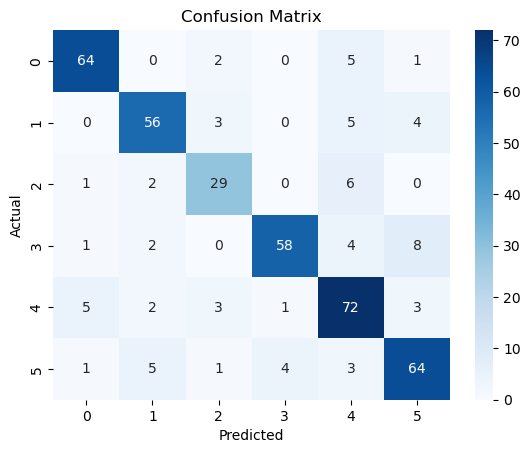

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        72
           1       0.84      0.82      0.83        68
           2       0.76      0.76      0.76        38
           3       0.92      0.79      0.85        73
           4       0.76      0.84      0.80        86
           5       0.80      0.82      0.81        78

    accuracy                           0.83       415
   macro avg       0.83      0.82      0.82       415
weighted avg       0.83      0.83      0.83       415



In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

# Load best model
model.load_state_dict(torch.load('best_emotion_model.pth'))
_, y_true, y_pred = evaluate(model, val_loader)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Detailed metrics
print(classification_report(y_true, y_pred))

In [53]:
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
print(f"Macro F1-score: {f1_macro:.4f}")
print(f"Weighted F1-score: {f1_weighted:.4f}")

Macro F1-score: 0.8234
Weighted F1-score: 0.8272


# Prediction through best_emotion_model.pth

In [54]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=180, hidden_dim=128, num_classes=6):  # CHANGED 8 → 6
        super(MLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),      
            nn.BatchNorm1d(hidden_dim),           
            nn.ReLU(),                            
            nn.Dropout(0.3),                        
            nn.Linear(hidden_dim, hidden_dim), 
            nn.BatchNorm1d(hidden_dim),           
            nn.ReLU(),
            nn.Dropout(0.3),                      
            nn.Linear(hidden_dim, num_classes)   
        )

    def forward(self, x):
        return self.model(x)

In [55]:
model = MLPClassifier(input_dim=180, num_classes=6)
model.load_state_dict(torch.load("best_emotion_model.pth"))
model.eval()

MLPClassifier(
  (model): Sequential(
    (0): Linear(in_features=180, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=6, bias=True)
  )
)

In [56]:
import librosa
import numpy as np

def extract_features(path):
    y, sr = librosa.load(path, duration=3, offset=0.5)
    
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0)
    rms = np.mean(librosa.feature.rms(y=y).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)
    features = np.hstack([mfccs, chroma, mel, zcr, rms, contrast, tonnetz])

    if len(features) < 180:
        features = np.pad(features, (0, 180 - len(features)))
    else:
        features = features[:180]

    return features

In [63]:
import torch
features = extract_features("C:/Users/Admin/OneDrive/Desktop/AudioFiles/03-01-03-01-01-01-08.wav")
features_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0)

In [64]:
emotion_labels = {
    0: "calm",
    1: "happy",
    2: "sad",
    3: "angry",
    4: "fearful",
    5: "disgust"
}

In [65]:
with torch.no_grad():
    output = model(features_tensor)  # shape: [1, 6]
    predicted_class = torch.argmax(output, dim=1).item()

print("Predicted class:", emotion_labels[predicted_class])


Predicted class: happy
